In [23]:
K_NUMBER = "K070165"
DEPTH = 5

In [24]:
!uv pip install networkx matplotlib scipy

Using Python 3.11.8 environment at: /Users/furkanmelih/personal_projects/complizen_case_project/.venv
Audited 3 packages in 19ms


In [25]:
import psycopg2
import networkx as nx
import matplotlib.pyplot as plt

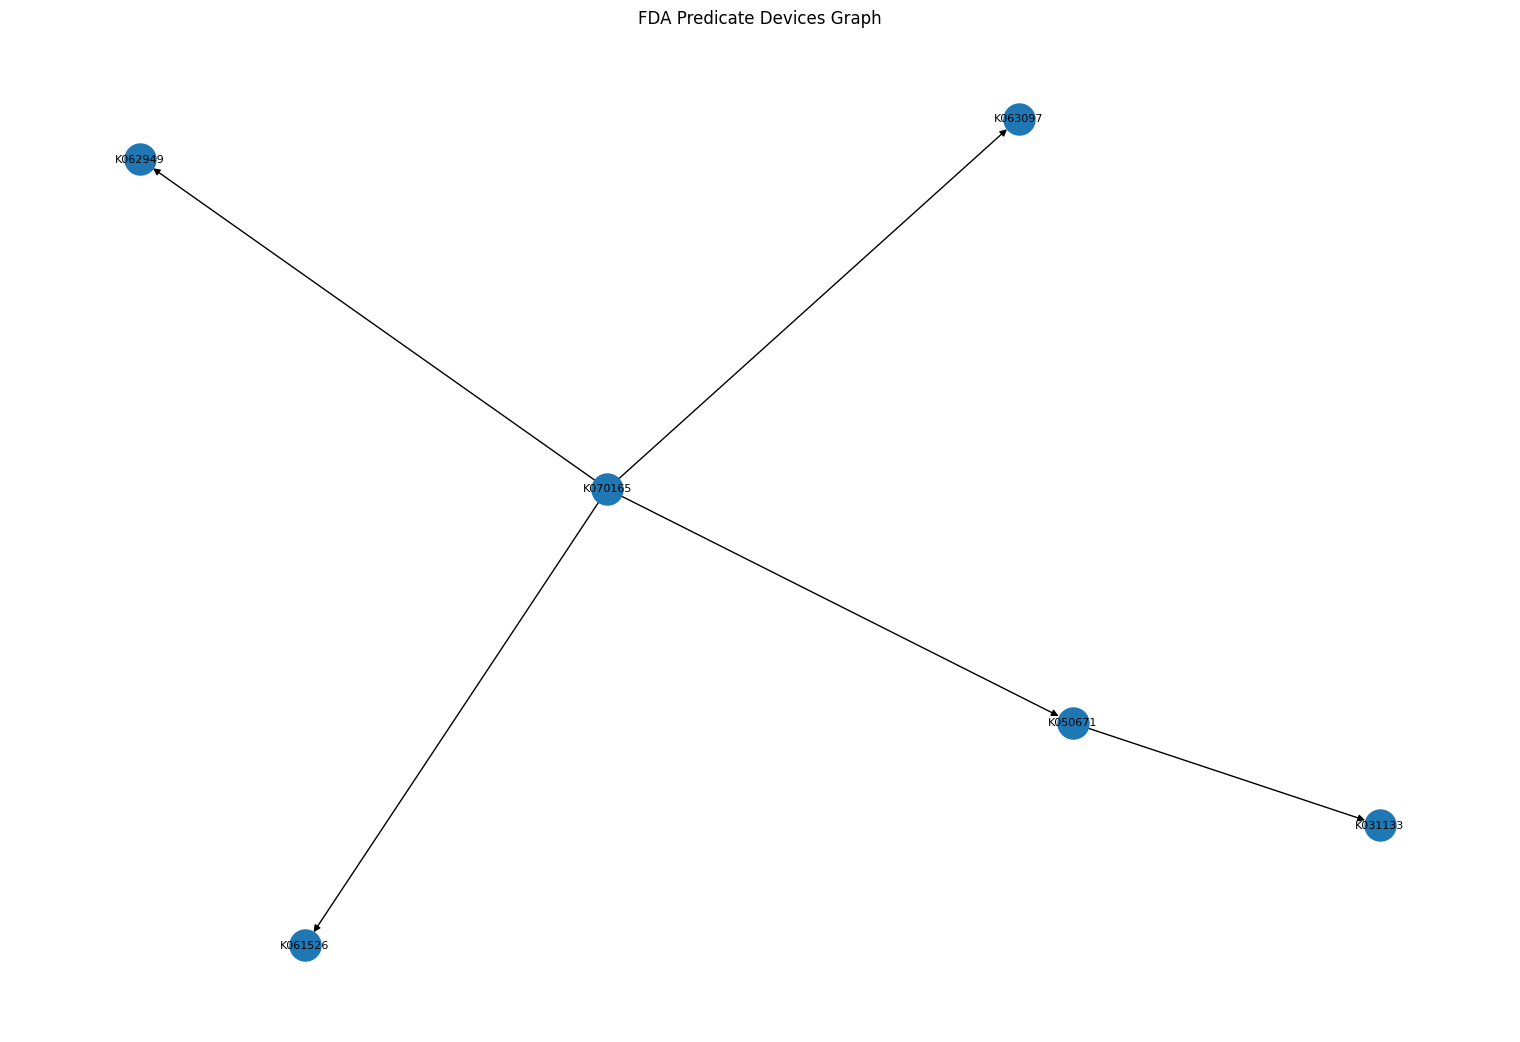

In [26]:
import psycopg2
import networkx as nx
import matplotlib.pyplot as plt

conn = psycopg2.connect(
    dbname="postgres",
    user="postgres",
    password="postgres",
    host="localhost",
    port="5432"
)
cur = conn.cursor()

cur.execute(f"""
    WITH RECURSIVE device_graph AS (
    SELECT
        fr.k_number AS source_k_number,
        pred AS target_k_number,
        1 as depth
    FROM
        fda_records fr,
        jsonb_array_elements_text(fr.predicate_devices) AS pred
    WHERE k_number = '{K_NUMBER}' AND k_number != ANY(ARRAY[pred])

    UNION ALL

    SELECT
        fr.k_number AS source_k_number,
        pred AS target_k_number,
        depth + 1
    FROM
        device_graph dg JOIN fda_records fr ON fr.k_number = dg.target_k_number,
        jsonb_array_elements_text(fr.predicate_devices) AS pred
    WHERE
       depth < {DEPTH}
)
SELECT f.source_k_number, f.target_k_number FROM (
    SELECT DISTINCT * FROM device_graph ORDER BY depth
) f
""")

edges = cur.fetchall()

# Build graph
G = nx.DiGraph()
G.add_edges_from(edges)

# Plot
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, k=0.5, iterations=50)
nx.draw(G, pos, with_labels=True, node_size=500, font_size=8, arrows=True)
plt.title("FDA Predicate Devices Graph")
plt.show()


In [27]:
print(edges)

[('K070165', 'K061526'), ('K070165', 'K050671'), ('K070165', 'K063097'), ('K070165', 'K062949'), ('K050671', 'K031133')]
